In [9]:
import math
import copy

In [ ]:
[[]]
[1, 2,3,4,5,6,7,8,9]

# 1

For my binary tree implementation, I was debating between storing it in a dictionary or a list. I thought that the issue with dictionaries is that there is no clear key value for a given value in the tree. For example, it could be a number like a heap index, but that wouldn't work with an unbalanced tree. I also considered an address like 'rrllrl' but I thought implementing this would be too convoluted.

This led me to settle on using a list. In the list implementation, I thought of giving each node in the tree its own list, with the value, and then pointers to the left and right branches. For the pointers I could put either the absolute index of the next branch, or the relative one. I decided to use the relative one because it is much easier to work with, as will become clear.

My first function was one which would construct this tree from a sorted list. Using an already sorted list allowed me to find the median easily, which means I could create a balanced tree.

You might notice that in this implementation nodes don't know their location in the tree, and have no access to their parent, but neither of these actions are necessary for using the binary tree.

Also, clearly the relative distance to the left branch is always 1 in a balanced tree, so this might seem redundant, however, I had a feeling that for certain applications it would be necessary to have an explicit pointer to the left branch, which proved true.

In [5]:
def construct_tree(sorted_array):
    n = len(sorted_array)
    new_tree = [[sorted_array[n//2], None, None]]
    if n > 1:
        new_tree[0][1] = 1
        new_tree.extend(construct_tree(sorted_array[:n//2]))
        if n > 2:
            new_tree[0][2] = len(new_tree)
            new_tree.extend(construct_tree(sorted_array[(n//2)+1:]))
    return new_tree

In [6]:
construct_tree([1,2,3,4,5,6,7,8,9])

[[5, 1, 5],
 [3, 1, 3],
 [2, 1, None],
 [1, None, None],
 [4, None, None],
 [8, 1, 3],
 [7, 1, None],
 [6, None, None],
 [9, None, None]]

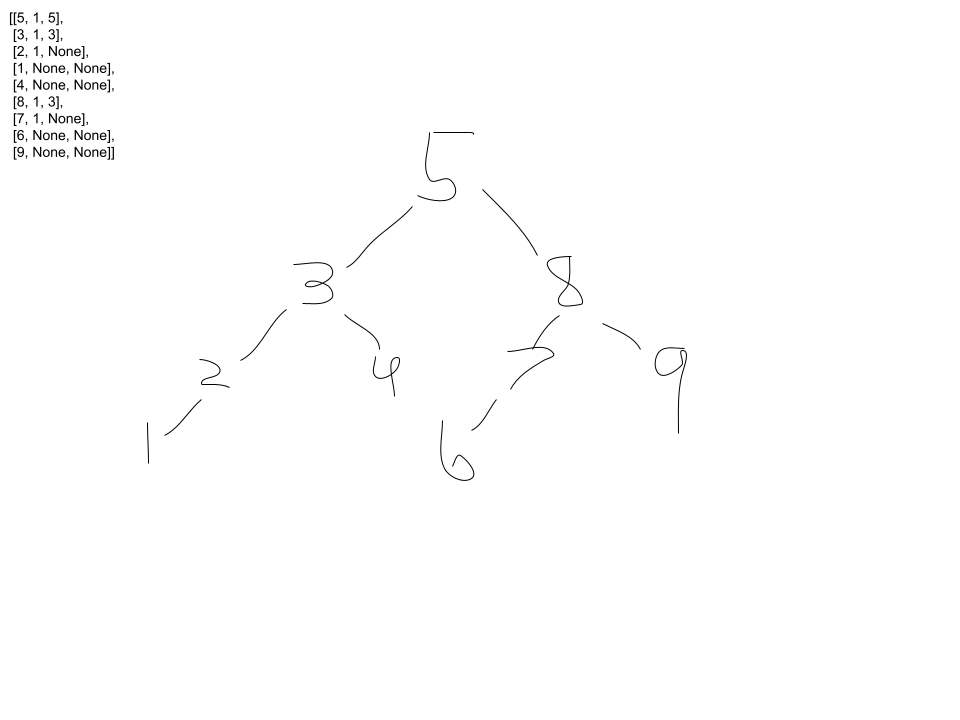

Testing whether it works with repeating values

In [7]:
construct_tree([1,2,3,4,5,5,6,7,8,9])

[[5, 1, 6],
 [3, 1, 3],
 [2, 1, None],
 [1, None, None],
 [5, 1, None],
 [4, None, None],
 [8, 1, 3],
 [7, 1, None],
 [6, None, None],
 [9, None, None]]

The next step was creating the insert function. My original attempt, old_insert() worked for basic insertions on a balanced tree, however once I got to the random tree in part 3, I encountered numerous bugs with it. The rewritten function, insert(), is less redundant.

insert() works the following way: For every node in the tree, it checks if x is bigger than the element. If so, if there is a right branch it goes down that branch, otherwise it inserts x as a new node there. To find the distance to the new right branch, we have to find the furthest element which is in the left branch, which we do with the distance_to_bottom_right() function. This function climbs down the left branch to the lowest point it finds, following the right branch whenever possible, as the rightmost branch should be the furthest. In old_insert I used a function called distance_to_bottom_left which followed the left branch all the way down on the left. This does not find the correct distance for the new right branch and I think was the source of many errors.

If x is smaller than the element, it increments the pointer to the right branch, because we know a new node will be inserted ahead of the right branch, so the relative distance increases by one. If there is not left branch, then a new one is inserted directly after the current node. Otherwise, it goes down the existing left branch and the process repeats.

The find_min() and delete_min() functions go down the left branch as far as they can, with delete_min() decrementing each right branch pointer it encounters in order to adjust the new relative distance once the node has been deleted. find_min() just returns the value of this far left node, while delete_min deletes it, returns it, and if it has a right node, links that branch as the new left branch of the above node.

In [12]:
def distance_to_bottom_left(tree):
    current_i = 0
    current_ele = tree[current_i]
    while current_ele[1] is not None:
        current_i += current_ele[1]
        current_ele = tree[current_i]
    return current_i

In [234]:
def distance_to_bottom_right(tree):  # after going left first
    if tree[0][1] is None:
        return 0
    current_i = tree[0][1]
    current_ele = tree[current_i]
    while True:
        if current_ele[2]:
            current_i += current_ele[2]
            current_ele = tree[current_i]
        elif current_ele[1]:
            current_i += current_ele[1]
            current_ele = tree[current_i]
        else:
            return current_i

In [35]:
def find_min(tree):
    current_i = 0
    current_ele = tree[current_i]
    while current_ele[1] is not None:
        current_i += current_ele[1]
        current_ele = tree[current_i]
    return current_ele[0]

In [277]:
def delete_min(tree):
    current_i = 0
    current_ele = tree[current_i]
    while current_ele[1] is not None:
        if tree[current_i][2] and tree[current_i][2] > tree[current_i][1]: tree[current_i][2] -= 1
        prev_i = current_i
        current_i += current_ele[1]
        current_ele = tree[current_i]
    if current_i > 0:
        if current_ele[2] is not None:
            tree[prev_i][1] += current_ele[2] - 1
        else:
            tree[prev_i][1] = None
    return tree.pop(current_i)

In [224]:
def exists(x, tree):
    current_i = 0
    current_ele = tree[current_i]
    while True:
        if x == current_ele[0]:
            return True
        elif x > current_ele[0]:
            if current_ele[2]:
                current_i += current_ele[2]
                current_ele = tree[current_i]
            else:
                return False
        elif x < current_ele[0]:
            if current_ele[1]:
                current_i += current_ele[1]
                current_ele = tree[current_i]
            else:
                return False
        else:
            raise ValueError

In [132]:
def old_insert(x, tree):
    #tree = copy.deepcopy(tree_i)
    current_i = 0
    current_ele = tree[current_i]
    while current_ele[2] is not None and current_ele[1] is not None:  # while we are on balanced parts of the tree
        if x > current_ele[0]:
            current_i += current_ele[2]
            current_ele = tree[current_i]
        elif x <= current_ele[0]:
            tree[current_i][2] += 1  # adjust relative distance to right branch due to new element in between
            current_i += current_ele[1]
            current_ele = tree[current_i]
    while current_ele[2] is not None:  # for when we've reached the zone where is it right leaning
        if x > current_ele[0]:
            current_i += current_ele[2]
            current_ele = tree[current_i]
        elif x <= current_ele[0]:
            tree[current_i][2] += 1
            tree[current_i][1] = 1
            tree.insert(current_i+1, [x, None, None])
            return tree
    while current_ele[1] is not None:  # for when we've reached the zone where is it left leaning
        if x > current_ele[0]:
            tree[current_i][2] = distance_to_bottom_left(tree[current_i:])+1  # prob makes it not maximally efficient
            tree.insert(current_i+tree[current_i][2], [x, None, None])
            return tree
        elif x <= current_ele[0]:
            current_i += current_ele[1]
            current_ele = tree[current_i]
    if x > current_ele[0]:  # when an element needs to be inserted on the right under a bottom node
        tree[current_i][2] = 1  # should always be 1 because otherwise loop wouldn't have ended?
        tree.insert(current_i+1, [x, None, None])
    else:
        tree[current_i][1] = 1
        tree.insert(current_i+1, [x, None, None])
    return tree

In [242]:
def insert(x, tree):
    #tree = copy.deepcopy(tree_i)
    current_i = 0
    current_ele = tree[current_i]
    while True:  # while we have not found our spot
        if x > current_ele[0]:
            if current_ele[2]: # is not None:
                current_i += current_ele[2]
                current_ele = tree[current_i]
            else:
                tree[current_i][2] = distance_to_bottom_right(tree[current_i:])+1  # prob makes it not maximally efficient
                tree.insert(current_i+tree[current_i][2], [x, None, None])
                return tree    
        elif x <= current_ele[0]:
            if current_ele[2]: # is not None:
                tree[current_i][2] += 1  # adjust relative distance to right branch due to new element in between
            if current_ele[1]: # is not None:
                current_i += current_ele[1]
                current_ele = tree[current_i]
            else:
                tree[current_i][1] = 1
                tree.insert(current_i+1, [x, None, None])
                return tree

In [14]:
test_bottom_left = [[7, 1, None],
[6, 1, None],
[5, None, None]]

In [15]:
distance_to_bottom_left(test_bottom_left)

2

Here I tested the insert function with values going in different places in the tree

In [144]:
initial_tree = construct_tree([1,2,3,4,5,6,7,8,9])

In [141]:
insert(7.5, initial_tree)

[[5, 1, 5],
 [3, 1, 3],
 [2, 1, None],
 [1, None, None],
 [4, None, None],
 [8, 1, 4],
 [7, 1, 2],
 [6, None, None],
 [7.5, None, None],
 [9, None, None]]

In [143]:
insert(10, initial_tree)

[[5, 1, 5],
 [3, 1, 3],
 [2, 1, None],
 [1, None, None],
 [4, None, None],
 [8, 1, 3],
 [7, 1, None],
 [6, None, None],
 [9, None, 1],
 [10, None, None]]

In [145]:
insert(2.5, initial_tree)

[[5, 1, 6],
 [3, 1, 4],
 [2, 1, 2],
 [1, None, None],
 [2.5, None, None],
 [4, None, None],
 [8, 1, 3],
 [7, 1, None],
 [6, None, None],
 [9, None, None]]

In [33]:
insert(5, initial_tree)

[[5, 1, 6],
 [3, 1, 3],
 [2, 1, None],
 [1, None, None],
 [4, None, 1],
 [5, None, None],
 [8, 1, 3],
 [7, 1, None],
 [6, None, None],
 [9, None, None]]

In [139]:
insert(5.5, initial_tree)

[[5, 1, 5],
 [3, 1, 3],
 [2, 1, None],
 [1, None, None],
 [4, None, None],
 [8, 1, 4],
 [7, 1, None],
 [6, 1, None],
 [5.5, None, None],
 [9, None, None]]

In [36]:
find_min(initial_tree)

1

In [39]:
construct_tree(list(range(1,16)))  # a perfectly balanced tree

[[8, 1, 8],
 [4, 1, 4],
 [2, 1, 2],
 [1, None, None],
 [3, None, None],
 [6, 1, 2],
 [5, None, None],
 [7, None, None],
 [12, 1, 4],
 [10, 1, 2],
 [9, None, None],
 [11, None, None],
 [14, 1, 2],
 [13, None, None],
 [15, None, None]]

In [51]:
sixteen = construct_tree(list(range(1,16)))
thirtytwo = construct_tree(list(range(1,32)))
sixtyfour = construct_tree(list(range(1,64)))
onetwoeight = construct_tree(list(range(1,128)))
twofiftysix = construct_tree(list(range(1,256)))
fivetwelve = construct_tree(list(range(1,512)))
tentwofour = construct_tree(list(range(1,1024)))

In [49]:
%time n = insert(0, onetwoeight)
%time n = insert(0, sixteen)
%time n = insert(0, thirtytwo)
%time n = insert(0, sixtyfour)
%time n = insert(0, onetwoeight)
%time n = insert(8, sixteen)
%time n = insert(16, thirtytwo)
%time n = insert(32, sixtyfour)
%time n = insert(64, onetwoeight)

CPU times: user 370 µs, sys: 1 µs, total: 371 µs
Wall time: 374 µs
CPU times: user 71 µs, sys: 0 ns, total: 71 µs
Wall time: 73.9 µs
CPU times: user 181 µs, sys: 5 µs, total: 186 µs
Wall time: 211 µs
CPU times: user 236 µs, sys: 1 µs, total: 237 µs
Wall time: 241 µs
CPU times: user 376 µs, sys: 0 ns, total: 376 µs
Wall time: 379 µs
CPU times: user 113 µs, sys: 5 µs, total: 118 µs
Wall time: 129 µs
CPU times: user 136 µs, sys: 0 ns, total: 136 µs
Wall time: 143 µs
CPU times: user 206 µs, sys: 1e+03 ns, total: 207 µs
Wall time: 211 µs
CPU times: user 445 µs, sys: 0 ns, total: 445 µs
Wall time: 467 µs


In [63]:
%time n = insert(0, tentwofour)
%time n = insert(0, tentwofour)
%time n = insert(0, fivetwelve)
%time n = insert(0, twofiftysix)
%time n = insert(0, onetwoeight)

%time n = insert(512, tentwofour)
%time n = insert(256, fivetwelve)
%time n = insert(128, twofiftysix)
%time n = insert(64, onetwoeight)

CPU times: user 3.45 ms, sys: 601 µs, total: 4.05 ms
Wall time: 3.47 ms
CPU times: user 3.34 ms, sys: 408 µs, total: 3.75 ms
Wall time: 3.54 ms
CPU times: user 1.41 ms, sys: 0 ns, total: 1.41 ms
Wall time: 1.42 ms
CPU times: user 727 µs, sys: 0 ns, total: 727 µs
Wall time: 732 µs
CPU times: user 630 µs, sys: 103 µs, total: 733 µs
Wall time: 643 µs
CPU times: user 3.53 ms, sys: 57 µs, total: 3.59 ms
Wall time: 3.66 ms
CPU times: user 1.6 ms, sys: 37 µs, total: 1.64 ms
Wall time: 1.69 ms
CPU times: user 723 µs, sys: 0 ns, total: 723 µs
Wall time: 726 µs
CPU times: user 412 µs, sys: 1e+03 ns, total: 413 µs
Wall time: 418 µs


In [60]:
%time n = insert(0, tentwofour)
%time n = insert(0, onetwoeight)
%time n = insert(0, twofiftysix)
%time n = insert(0, fivetwelve)
%time n = insert(0, tentwofour)

%time n = insert(64, onetwoeight)
%time n = insert(32, twofiftysix)
%time n = insert(16, fivetwelve)
%time n = insert(8, tentwofour)

CPU times: user 3.68 ms, sys: 81 µs, total: 3.76 ms
Wall time: 4.88 ms
CPU times: user 807 µs, sys: 0 ns, total: 807 µs
Wall time: 823 µs
CPU times: user 812 µs, sys: 7 µs, total: 819 µs
Wall time: 829 µs
CPU times: user 2.31 ms, sys: 43 µs, total: 2.35 ms
Wall time: 2.47 ms
CPU times: user 3.92 ms, sys: 137 µs, total: 4.05 ms
Wall time: 4.33 ms
CPU times: user 418 µs, sys: 6 µs, total: 424 µs
Wall time: 432 µs
CPU times: user 676 µs, sys: 0 ns, total: 676 µs
Wall time: 680 µs
CPU times: user 1.36 ms, sys: 9 µs, total: 1.37 ms
Wall time: 1.39 ms
CPU times: user 2.77 ms, sys: 21 µs, total: 2.79 ms
Wall time: 2.8 ms


In [72]:
_20 = construct_tree(list(range(1,2**20)))
_22 = construct_tree(list(range(1,2**22)))
_24 = construct_tree(list(range(1,2**24)))

In [71]:
%time n = insert(0, _20)
%time n = insert(0, _20)
%time n = insert(0, _22)
%time n = insert(0, _24)

%time n = insert(2**19, _20)
%time n = insert(2**21, _22)
%time n = insert(2**23, _24)

CPU times: user 798 ms, sys: 710 ms, total: 1.51 s
Wall time: 1.79 s
CPU times: user 1.1 ms, sys: 5 µs, total: 1.11 ms
Wall time: 1.12 ms
CPU times: user 6.13 ms, sys: 4.12 ms, total: 10.2 ms
Wall time: 11.4 ms
CPU times: user 29.5 ms, sys: 11.6 ms, total: 41.1 ms
Wall time: 42.9 ms
CPU times: user 407 µs, sys: 1e+03 ns, total: 408 µs
Wall time: 410 µs
CPU times: user 1.63 ms, sys: 7 µs, total: 1.64 ms
Wall time: 1.64 ms
CPU times: user 6.76 ms, sys: 96 µs, total: 6.86 ms
Wall time: 6.93 ms


In [73]:
%time n = find_min(_24)
%time n = find_min(_20)
%time n = find_min(_22)
%time n = find_min(_24)

%time n = insert(0, _20)
%time n = insert(0, _22)
%time n = insert(0, _24)

%time n = insert(2**19, _20)
%time n = insert(2**21, _22)
%time n = insert(2**23, _24)

CPU times: user 759 ms, sys: 276 ms, total: 1.03 s
Wall time: 1.04 s
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 9.78 µs
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 9.06 µs
CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11 µs
CPU times: user 1.78 ms, sys: 1.3 ms, total: 3.08 ms
Wall time: 2.72 ms
CPU times: user 6.93 ms, sys: 4.33 ms, total: 11.3 ms
Wall time: 11.3 ms
CPU times: user 33.1 ms, sys: 16.7 ms, total: 49.8 ms
Wall time: 49.9 ms
CPU times: user 551 µs, sys: 7 µs, total: 558 µs
Wall time: 564 µs
CPU times: user 1.89 ms, sys: 4 µs, total: 1.89 ms
Wall time: 1.9 ms
CPU times: user 7.42 ms, sys: 127 µs, total: 7.55 ms
Wall time: 7.66 ms


While the differences between subsequent functions should be constant since the log n difference is constant, it looks like this doesn't hold so well. It appears that the find_min function has a negligible impact from the number of elements or their log, while the insert function is strongly impacted by n (which can be deduced from the differences doubling for an n twice as large). I am not sure whether there is something in Python which might cause this, or whether my impelementation is just super inefficient.

# 2
Now I will investigate the runtime for extremely unbalanced worst case input trees.

In [88]:
new1024 = construct_tree([1024])
for num in range(1023, 1, -1):
    new1024 = insert(num, new1024)

new2048 = construct_tree([2048])
for num in range(2047, 1, -1):
    new2048 = insert(num, new2048)
    
new4096 = construct_tree([4096])
for num in range(4095, 1, -1):
    new4096 = insert(num, new4096)

In [89]:
%time n = find_min(new2048)
%time n = find_min(new1024)
%time n = find_min(new2048)
%time n = find_min(new4096)

%time n = insert(0, new1024)
%time n = insert(0, new2048)
%time n = insert(0, new4096)

%time n = insert(512, new1024)
%time n = insert(1024, new2048)
%time n = insert(2048, new4096)

CPU times: user 390 µs, sys: 267 µs, total: 657 µs
Wall time: 1.13 ms
CPU times: user 116 µs, sys: 1e+03 ns, total: 117 µs
Wall time: 118 µs
CPU times: user 191 µs, sys: 0 ns, total: 191 µs
Wall time: 194 µs
CPU times: user 384 µs, sys: 0 ns, total: 384 µs
Wall time: 387 µs
CPU times: user 194 µs, sys: 0 ns, total: 194 µs
Wall time: 197 µs
CPU times: user 356 µs, sys: 1 µs, total: 357 µs
Wall time: 359 µs
CPU times: user 758 µs, sys: 0 ns, total: 758 µs
Wall time: 766 µs
CPU times: user 169 µs, sys: 0 ns, total: 169 µs
Wall time: 177 µs
CPU times: user 295 µs, sys: 1e+03 ns, total: 296 µs
Wall time: 302 µs
CPU times: user 538 µs, sys: 9 µs, total: 547 µs
Wall time: 552 µs


With the worst case binary trees, the theoretical runtime complexity of O(n) seems to hold. The runtime difference between 2048 and 4096 is nearly double that between 1024 and 2048 for all the functions, as we would expect given their O(n) complexity.

# 3
I first test a perfectly balanced tree, then a completely degenerate one, and finally I construct a completely random tree to not cheat by sorting it, which I build by inserting each element from a shuffled list, and test it as well.

## Balanced Tree

In [293]:
base_tree = construct_tree(list(range(1,1024)))

In [178]:
len(base_tree)

1023

In [294]:
sorted_list = []
for _ in range(len(base_tree)):
    sorted_list.append(delete_min(base_tree)[0])

In [295]:
sorted_list[::20]

[1,
 21,
 41,
 61,
 81,
 101,
 121,
 141,
 161,
 181,
 201,
 221,
 241,
 261,
 281,
 301,
 321,
 341,
 361,
 381,
 401,
 421,
 441,
 461,
 481,
 501,
 521,
 541,
 561,
 581,
 601,
 621,
 641,
 661,
 681,
 701,
 721,
 741,
 761,
 781,
 801,
 821,
 841,
 861,
 881,
 901,
 921,
 941,
 961,
 981,
 1001,
 1021]

In [296]:
base_tree

[]

## Degenerate Tree

In [289]:
base_tree = construct_tree([1024])
for num in range(1023, 0, -1):
    base_tree = insert(num, base_tree)

In [290]:
sorted_list = []
for _ in range(len(base_tree)):
    sorted_list.append(delete_min(base_tree)[0])

In [291]:
sorted_list[::20]

[1,
 21,
 41,
 61,
 81,
 101,
 121,
 141,
 161,
 181,
 201,
 221,
 241,
 261,
 281,
 301,
 321,
 341,
 361,
 381,
 401,
 421,
 441,
 461,
 481,
 501,
 521,
 541,
 561,
 581,
 601,
 621,
 641,
 661,
 681,
 701,
 721,
 741,
 761,
 781,
 801,
 821,
 841,
 861,
 881,
 901,
 921,
 941,
 961,
 981,
 1001,
 1021]

In [292]:
base_tree

[]

## Random Tree

In [90]:
import random

In [97]:
to_sort = list(range(1, 256))
random.shuffle(to_sort)

In [278]:
base_tree = construct_tree([to_sort[0]])
for num in to_sort[1:]:
    base_tree = insert(num, base_tree)

In [241]:
for num in to_sort:  # with old_insert()
    if not exists(num, base_tree):
        print(num)

78
89
102
34
119
20
233
117
24
118
236
255
193
252
48
248
49
229
230
103
247
186
104
83
237
188
73
87
249
226
133
76
132
194
240
243
191
55
197
159
235
239
158
52
53
170


In [265]:
for num in to_sort:  # with insert()
    if not exists(num, base_tree):
        print(num)  # nothing is printed

In [273]:
to_sort[:10]

[120, 153, 176, 130, 138, 2, 116, 199, 181, 28]

In [275]:
base_tree[:10]

[[120, 1, 120],
 [2, 1, 2],
 [1, None, None],
 [116, 1, 114],
 [28, 1, 26],
 [8, 1, 6],
 [5, 1, 3],
 [4, 1, None],
 [3, None, None],
 [7, 1, None]]

In [279]:
sorted_list = []

In [280]:
for _ in range(len(base_tree)):
    sorted_list.append(delete_min(base_tree)[0])

In [191]:
sorted_list  # with old_insert()

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 23,
 25,
 26,
 27,
 24,
 22,
 20,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 54,
 47,
 50,
 52,
 53,
 55,
 51,
 48,
 49,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 75,
 76,
 74,
 73,
 77,
 79,
 80,
 81,
 82,
 86,
 84,
 87,
 85,
 83,
 88,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 105,
 103,
 104,
 113,
 114,
 115,
 117,
 118,
 119,
 116,
 34,
 78,
 89,
 102,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 136,
 137,
 134,
 135,
 132,
 133,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 161,
 160,
 158,
 159,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 172,
 171,
 170,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [268]:
sorted_list  # with insert()

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [281]:
base_tree

[]

Now to try it with the full 1024 list

In [282]:
to_sort = list(range(1, 1024))
random.shuffle(to_sort)

In [283]:
base_tree = construct_tree([to_sort[0]])
for num in to_sort[1:]:
    base_tree = insert(num, base_tree)

In [284]:
sorted_list = []

In [285]:
for _ in range(len(base_tree)):
    sorted_list.append(delete_min(base_tree)[0])

In [288]:
sorted_list[::20]

[1,
 21,
 41,
 61,
 81,
 101,
 121,
 141,
 161,
 181,
 201,
 221,
 241,
 261,
 281,
 301,
 321,
 341,
 361,
 381,
 401,
 421,
 441,
 461,
 481,
 501,
 521,
 541,
 561,
 581,
 601,
 621,
 641,
 661,
 681,
 701,
 721,
 741,
 761,
 781,
 801,
 821,
 841,
 861,
 881,
 901,
 921,
 941,
 961,
 981,
 1001,
 1021]